### Prepare storage and get Data

In [0]:
!wget -O data.zip http://hck.re/TT3Xkb

--2019-09-29 06:43:55--  http://hck.re/TT3Xkb
Resolving hck.re (hck.re)... 52.220.222.195, 54.169.54.236, 13.250.79.191
Connecting to hck.re (hck.re)|52.220.222.195|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Cookie coming from hck.re attempted to set domain to hackerearth.com
Cookie coming from hck.re attempted to set domain to hackerearth.com
Cookie coming from hck.re attempted to set domain to hackerearth.com
Location: https://he-s3.s3.amazonaws.com/media/hackathon/hdfc-bank-ml-hiring-challenge-2019/banking-behavioral-scorecard-for-internal-liability-customers-4caf1786/d407ebe0db9a11e9.zip [following]
--2019-09-29 06:43:56--  https://he-s3.s3.amazonaws.com/media/hackathon/hdfc-bank-ml-hiring-challenge-2019/banking-behavioral-scorecard-for-internal-liability-customers-4caf1786/d407ebe0db9a11e9.zip
Resolving he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)... 52.219.36.112
Connecting to he-s3.s3.amazonaws.com (he-s3.s3.amazonaws.com)|52.219.36.112|:4

In [0]:
!unzip data.zip

Archive:  data.zip
   creating: DataSet/
  inflating: DataSet/Train.csv       
  inflating: DataSet/Sample_submission.csv  
  inflating: DataSet/Test.csv        


### Understanding the Problem statement

Referring to the competition description 

``The definition that is used for the target variable is every 30+ or X+ days delinquent twice in forward  12 months.``

This problem is detailed in this [article](https://www.analyticsindiamag.com/banking-analytics-basics-developing-customer-level-behaviour-scorecard/)

If I understand correctly the target variable predicts the number of times that the particular customer will become delinquent (i.e). Fails to pay his dues in the period mentioned. for the **30** or **X days** in the period of 12 months.

###Import Libraries

In [0]:
import pandas as pd
from tqdm import tqdm_notebook
from pathlib import Path

### Read data

In [0]:
DATA_PATH = Path('DataSet')

In [0]:
train_data = pd.read_csv(DATA_PATH/'Train.csv')
train_data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (746,835) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,Col22,Col23,Col24,Col25,Col26,Col27,Col28,Col29,Col30,Col31,Col32,Col33,Col34,Col35,Col36,Col37,Col38,Col39,Col40,...,Col2358,Col2359,Col2360,Col2361,Col2362,Col2363,Col2364,Col2365,Col2366,Col2367,Col2368,Col2369,Col2370,Col2371,Col2372,Col2373,Col2374,Col2375,Col2376,Col2377,Col2378,Col2379,Col2380,Col2381,Col2382,Col2383,Col2384,Col2385,Col2386,Col2387,Col2388,Col2389,Col2390,Col2391,Col2392,Col2393,Col2394,Col2395,Col2396,Col2397
0,RIGHGSN,1,1.086711e+04,8.648345e+03,1.576618e+04,2.890466e+04,5.273655e+03,2.346153e+04,1.285597e+04,2.871509e+04,9.114586e+03,3.043078e+04,9.293496,8.570479,10.063117,10.271758,0.548538,0.403366,NaN,NaN,1.486524,1.728324,0.993441,1.297050,0.137398,0.115987,0.260428,1.414214,1,1,1,1,1,1,0,6,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,214.0,214.0,68.0,22.0,22.0,7.0
1,RIMHI5ZGP,0,2.584312e+05,2.179633e+05,1.866287e+05,1.866287e+05,2.154519e+05,1.923615e+05,1.726538e+05,1.666974e+05,2.013518e+05,1.859404e+05,12.462385,12.280493,12.167132,12.136876,1.167898,2.676398,NaN,NaN,0.792123,0.934556,0.893203,0.966620,0.753892,0.808295,1.414214,NaN,1,1,3,4,4,0,4,5,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41.0,41.0,38.0,12.0,12.0,11.0
2,RIHOG1SZU,0,1.459355e+07,1.260060e+07,1.100315e+07,1.010315e+07,1.879882e+07,1.514035e+07,5.320778e+06,6.906324e+06,9.368338e+06,1.113330e+07,16.496090,16.749305,16.532874,16.128357,1.145182,2.203874,NaN,NaN,0.422264,0.498347,0.683582,0.735339,0.808115,0.776910,1.414214,NaN,3,3,4,12,4,0,2,4,NaN,1.0,NaN,NaN,...,1,0,1,0,1,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,378.0,378.0,310.0,21.0,21.0,16.0
3,RIHOLMQWU,0,6.727043e+05,8.181116e+05,6.794893e+05,6.794893e+05,8.257254e+05,7.605803e+05,3.577134e+05,4.236612e+05,4.304848e+05,4.065539e+05,13.419061,13.624018,13.541837,13.429097,1.204010,0.536304,NaN,NaN,0.437243,0.521341,0.623499,0.534531,-0.125829,0.388830,-1.414214,NaN,2,2,2,24,1,0,1,4,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1,2,0,1,2,0,0,0,0,0,1,2,0,0,0,0,0,1,2,0,0,0,0,0,0,702.0,702.0,644.0,951.0,951.0,743.0
4,RIHO584ET,0,-1.218742e+06,-3.005361e+06,-1.666241e+05,-2.403574e+06,2.583183e+06,2.086546e+06,5.938358e+06,5.446532e+06,3.473444e+06,3.262168e+06,NaN,14.764533,14.551021,NaN,NaN,NaN,NaN,NaN,NaN,1.344637,NaN,1.563430,-0.113101,0.617486,1.414214,NaN,4,3,4,68,8,0,2,4,NaN,3.0,NaN,NaN,...,0,0,0,0,0,0,2,1,0,0,0,0,2,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1305.0,1305.0,1211.0,2205.0,2205.0,1831.0


In [0]:
test_data = pd.read_csv(DATA_PATH/'Test.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (700,731,740,752,761,789,811,820,829,841,850) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Check Target Classes

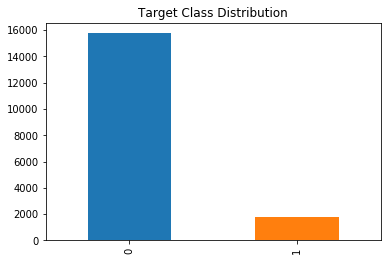

In [0]:
train_data.Col2.value_counts().plot.bar(title='Target Class Distribution')

### Check data

In [0]:
train_data.shape

(17521, 2395)

This is a huge number of columns, Most of them may be useless for our target variable, 

We have been warned by pandas that Column number **746** and Column number Column number **835** has mixed dtypes. We should be wary of them.

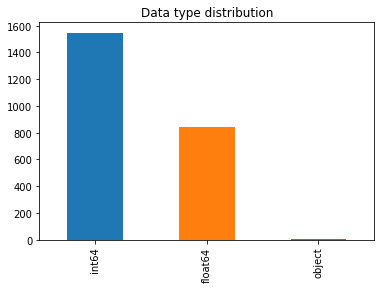

In [0]:
train_data.dtypes.value_counts().plot.bar(title='Data type distribution')

Let's check the object type columns since that is quite low in the dataset

In [0]:
object_cols = train_data.select_dtypes(['object'])
object_cols.head()

,Col1,Col747,Col836
0,RIGHGSN,NaN,NaN
1,RIMHI5ZGP,NaN,NaN
2,RIHOG1SZU,NaN,NaN
3,RIHOLMQWU,NaN,NaN
4,RIHO584ET,NaN,NaN


### Data Cleaning

#### Let's check the number of nan values

In [0]:
object_cols.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 3 columns):
Col1      17521 non-null object
Col747    626 non-null object
Col836    624 non-null object
dtypes: object(3)
memory usage: 410.7+ KB


In [0]:
pct_nonnan_col747 = (626/train_data.shape[0])*100
pct_nonnan_col836 = (624/train_data.shape[0])*100
print(f"% of non NAN values in the columns is Col747: {pct_nonnan_col747:.5f}% and Col836: {pct_nonnan_col836:.5f}%")

% of non NAN values in the columns is Col747: 3.57286% and Col836: 3.56144%


Ignoring **Col1** since it is an ID column and highly unlikely to have any information, we can see that it has too many **NaN** values, let's check the values present in the columns

In [0]:
object_cols.loc[:, 'Col747'].value_counts()

0      443
-      133
0.0     46
1        2
3        1
5.0      1
Name: Col747, dtype: int64

In [0]:
object_cols.loc[:, 'Col836'].value_counts()

0      438
-      144
0.0     41
5        1
Name: Col836, dtype: int64

Assuming that the columns represent some flag, there are barely enough number of values and the **-** hyphen present should also be a **NaN** value, which further increases the **NaN** values here. So these features can be considered **useless**.

In [0]:
# Track unusable feature columns
unusable_columns = [ 'Col1',    # ID column
                     'Col747',  # Too many missing values
                     'Col836'   # Too many missing values
                     ]

#### Check NaN values in full dataset

It is hard to **visualize** and **explore** when we have **2395** columns, so we should focus on **filtering** the **features** that are not useful by statistical methods.

One method is to filter features by the number of **null/NaN** values in them. Let's 
calculate them.

In [0]:
from feature_selector import FeatureSelector
fs = FeatureSelector(data=train_data.drop(['Col1', 'Col2'], axis=1), labels=train_data['Col2'])

#### Find number of features with too many missing/NaN values

In [0]:
fs.identify_missing(missing_threshold=0.75)

159 features with greater than 0.75 missing values.



In [0]:
fs.ops['missing'][:10]

['Col19',
 'Col20',
 'Col37',
 'Col38',
 'Col39',
 'Col40',
 'Col41',
 'Col138',
 'Col139',
 'Col140']

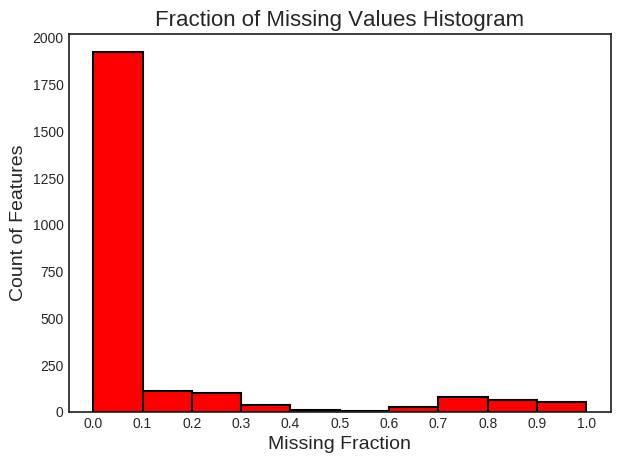

In [0]:
fs.plot_missing()

#### Identify values with only one unique value

In [0]:
fs.identify_single_unique()

2 features with a single unique value.



In [0]:
fs.ops['single_unique']

['Col724', 'Col813']

#### Plot number of unique values in data

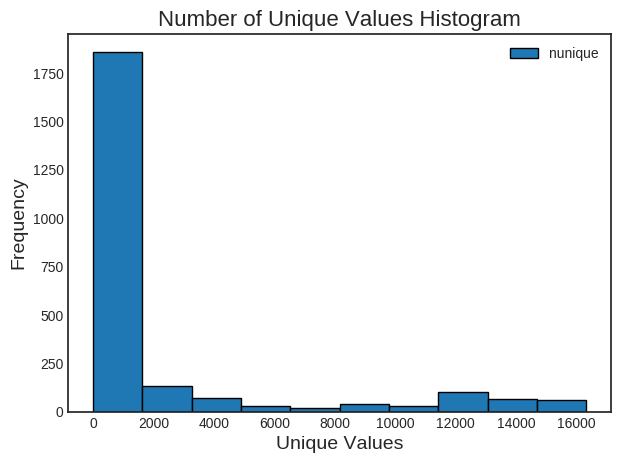

In [0]:
fs.plot_unique()

#### Identify Collinearity/Correlation between features

In [0]:
fs.identify_collinear(correlation_threshold = 0.98)

1316 features with a correlation magnitude greater than 0.98.



In [0]:
fs.ops['collinear'][:10]

['Col4',
 'Col6',
 'Col7',
 'Col8',
 'Col12',
 'Col15',
 'Col53',
 'Col55',
 'Col57',
 'Col59']

#### Check Top feature correlations

In [0]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,Col4,Col3,0.982237
1,Col6,Col3,0.988359
2,Col6,Col4,0.993567
3,Col7,Col3,0.982670
4,Col7,Col4,0.994026


In [0]:
len(fs.check_removal())

Total of 1394 features identified for removal


1394

#### Run a machine learning model to find feature importances

In [0]:
fs.identify_zero_importance(task='classification', eval_metric='auc', n_iterations=10, early_stopping=True)

Training Gradient Boosting Model

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[61]	valid_0's auc: 0.720428
Early stopping, best iteration is:
[61]	valid_0's auc: 0.720428
Training until validation scores don't improve for 100 rounds.
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[96]	valid_0's auc: 0.744503
Early stopping, best iteration is:
[96]	valid_0's auc: 0.744503
Training until validation scores don't improve for 100 rounds.
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[70]	valid_0's auc: 0.720064
Early stopping, best iteration is:
[70]	valid_0's auc: 0.720064
Training until validation scores don't improve for 100 rounds.
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[114]	val

In [0]:
one_hot_features = fs.one_hot_features
base_features = fs.base_features
print('There are %d original features' % len(base_features))
print('There are %d one-hot features' % len(one_hot_features))

There are 2393 original features
There are 10 one-hot features


In [0]:
fs.ops['zero_importance'][:5]

['Col1946', 'Col747_5.0', 'Col1955', 'Col1947', 'Col1952']

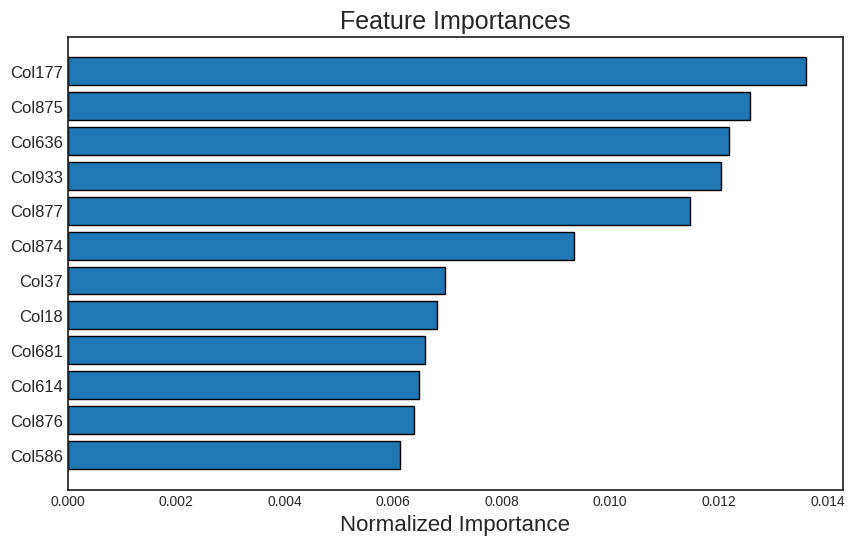

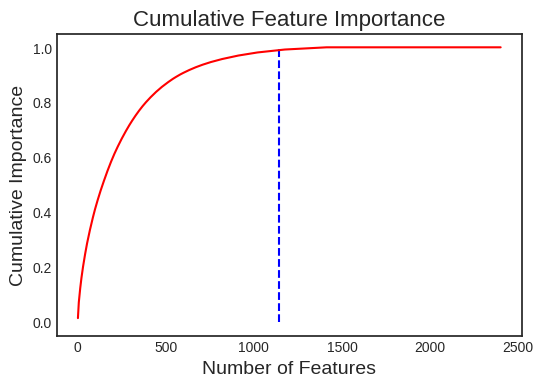

1144 features required for 0.99 of cumulative importance


In [0]:
fs.plot_feature_importances(threshold = 0.99, plot_n = 12)

So only **1144** features account for **99%** of feature importance in model.

In [0]:
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,Col177,38.2,0.013604,0.013604
1,Col875,35.3,0.012571,0.026175
2,Col636,34.2,0.012179,0.038355
3,Col933,33.8,0.012037,0.050392
4,Col877,32.2,0.011467,0.061859
5,Col874,26.2,0.009330,0.071189
6,Col37,19.5,0.006944,0.078134
7,Col18,19.1,0.006802,0.084936
8,Col681,18.5,0.006588,0.091524
9,Col614,18.2,0.006481,0.098006


In [0]:
fs.identify_low_importance(cumulative_importance = 0.99)

1143 features required for cumulative importance of 0.99 after one hot encoding.
1258 features do not contribute to cumulative importance of 0.99.



#### Check features chosen for removal

In [0]:
useless_features = fs.check_removal(keep_one_hot=False)

Total of 1718 features identified for removal
0 additional one-hot features can be removed


### Conclusion

So we have selected **1718** features excluding the ID column to be useless, so now we are down to only **677** to predict with. Let's save those feature names.

In [0]:
'Col1' in useless_features

False

In [0]:
useless_features.append('Col1')

In [0]:
import pickle
with open('useless_features', 'wb') as f:
    pickle.dump(useless_features, f)